# Prediction with pre-trained CNNs
This notebook contains all the code you need to use a pre-trained OpenSoundscape convolutional neural network model (CNN) to make predictions on your own data. Before attempting this tutorial, install OpenSoundscape by following the instructions on the OpenSoundscape website, [opensoundscape.org](http://opensoundscape.org/). More detailed tutorials about data preprocessing, training CNNs, and customizing prediction methods can also be found on this site.

Note that prediction no longer requires you to split your files into clips ahead of time - you can simply create a list of audio files of arbitrary length. Prediction scores will be generated on windows of a fixed length, eg 5 seconds, for the duration of each audio file. 

## Load required packages

The `cnn` module provides a function `load_model` to load saved opensoundscape models

In [1]:
from opensoundscape.torch.models.cnn import load_model, load_outdated_model
import opensoundscape

load some additional packages and perform some setup for the Jupyter notebook.

In [2]:
# Other utilities and packages
import torch
from pathlib import Path
import numpy as np
import pandas as pd
from glob import glob
import subprocess

In [3]:
#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

For this example, let's create an untrained model and save it. This 2-class model is not actually good at recognizing any particular species, but it's useful for illustrating how prediction works. 


In [48]:
from opensoundscape.torch.models.cnn import CNN
CNN('resnet18',['classA','classB'],5.0).save('./temp.model')

### Load a saved model

load the model object using the `load_model` function imported above

In [50]:
model = load_model('./temp.model')

### Choose audio files for prediction

Create a list of audio files to predict on. They can be of any length. Consider using `glob` to find many files at once.

For this example, let's download a 1-minute audio clip from the Kitzes Lab box to use as an example.

In [51]:
subprocess.run(['curl',
               'https://pitt.box.com/shared/static/z73eked7quh1t2pp93axzrrpq6wwydx0.wav', 
                '-L', '-o', '1min_audio.wav'])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     7    0     7    0     0      5      0 --:--:--  0:00:01 --:--:--     0
100 3750k  100 3750k    0     0  1396k      0  0:00:02  0:00:02 --:--:-- 3446k


CompletedProcess(args=['curl', 'https://pitt.box.com/shared/static/z73eked7quh1t2pp93axzrrpq6wwydx0.wav', '-L', '-o', '1min_audio.wav'], returncode=0)

In [52]:
from glob import glob 
audio_files = glob('./*.wav') #match all .wav files in the current directory
audio_files

['./1min_audio.wav']

## generate predictions with the model
The model returns a dataframe with a MultiIndex of file, start_time, and end_time. There is one column for each class. 

In [53]:
scores, _, _ = model.predict(audio_files)
scores.head()

classA    classB
file             start_time end_time                    
./1min_audio.wav 0.0        5.0      -0.014681  0.394269
                 5.0        10.0      0.162471  0.223495
                 10.0       15.0     -0.412240  0.413294
                 15.0       20.0     -0.089480  0.528132
                 20.0       25.0     -0.214247  0.450105

## Overlapping prediction clips

In [54]:
scores, _, _ = model.predict(audio_files, overlap_fraction=0.5)
scores.head()

classA    classB
file             start_time end_time                    
./1min_audio.wav 0.0        5.0      -0.014681  0.394269
                 2.5        7.5       0.055817  0.306112
                 5.0        10.0      0.162471  0.223495
                 7.5        12.5     -0.327899  0.408404
                 10.0       15.0     -0.412240  0.413294

## Using models from older OpenSoundscape versions

### Models from OpenSoundscape 0.4.x and 0.5.x
Models trained and saved with OpenSoundscape versions 0.4.x and 0.5.x need to be loaded in a different way, and require that you know the architecture of the saved model.

For example, one set of our publicly availably [binary models for 500 species](https://pitt.app.box.com/s/3048856qbm9x55yi3zfksa3fide5uuf4) was created with an older version of OpenSoundscape. These models require a little bit of manipulation to load into OpenSoundscape 0.5.x and onward. 

First, let's download one of these models (it's stored in a .tar format) and save it to the same directory as this notebook in a file called `opso_04_model_acanthis-flammea.tar`

In [65]:
subprocess.run(['curl',
               'https://pitt.box.com/shared/static/lglpty35omjhmq6cdz8cfudm43nn2t9f.tar', 
                '-L', '-o', 'opso_04_model_acanthis-flammea.tar'])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     8    0     8    0     0      6      0 --:--:--  0:00:01 --:--:--     0
100 42.9M  100 42.9M    0     0  5055k      0  0:00:08  0:00:08 --:--:-- 9454k


CompletedProcess(args=['curl', 'https://pitt.box.com/shared/static/lglpty35omjhmq6cdz8cfudm43nn2t9f.tar', '-L', '-o', 'opso_04_model_acanthis-flammea.tar'], returncode=0)

using torch.load() we can access the contents of the saved model as a dictionary

In [66]:
model_dict = torch.load('./opso_04_model_acanthis-flammea.tar')
model_dict.keys()

dict_keys(['train_loss', 'train_accuracy', 'train_precision', 'train_recall', 'train_f1', 'train_confusion_matrix', 'valid_accuracy', 'valid_precision', 'valid_recall', 'valid_f1', 'valid_confusion_matrix', 'model_state_dict', 'optimizer_state_dict', 'labels_yaml', 'train_scores', 'train_targets', 'valid_scores', 'valid_targets'])

One thing we'll need from the saved model is a list of classes. Here's how we can extract that from models saved in older opso versions:

In [67]:
# get the list of classes
if "classes" in model_dict:
    classes = model_dict["classes"]
elif "labels_yaml" in model_dict:
    import yaml

    classes = list(yaml.safe_load(model_dict["labels_yaml"]).values())
else:
    raise ValueError("Could not get a list of classes from the saved model.")
classes

['acanthis-flammea-absent', 'acanthis-flammea-present']

From the model notes page, we know that this is a single-target model with a resnet18 architecture trained on 5 second files. Let's create a CNN object then load the saved weights: 

In [68]:
model = CNN('resnet18',classes,sample_duration=5.0)
model.network.load_state_dict(model_dict['model_state_dict'])

<All keys matched successfully>

The model is now fully compatible with OpenSoundscape, and can be used as above. For example:

In [59]:
scores, _, _ = model.predict(audio_files)
scores.head()

acanthis-flammea-absent  \
file             start_time end_time                            
./1min_audio.wav 0.0        5.0                      2.994287   
                 5.0        10.0                     3.646061   
                 10.0       15.0                     3.004456   
                 15.0       20.0                     3.158881   
                 20.0       25.0                     2.755805   

                                      acanthis-flammea-present  
file             start_time end_time                            
./1min_audio.wav 0.0        5.0                      -3.261499  
                 5.0        10.0                     -3.892005  
                 10.0       15.0                     -2.484303  
                 15.0       20.0                     -3.852344  
                 20.0       25.0                     -2.693598

### Loading models from OpenSoundscape 0.6.x

If you saved a model with OpenSoundscape 0.6.x and want to use it in 0.7.0 or above, you will need to re-load the model using the original OpenSoundscape version that it was created with and save the model's weights explicitly:

```
#OpenSoundscape version 0.6.x
model = load_model('/path/to/saved.model')

dict_to_save = {
    'network_state_dict':model.network.state_dict(),
    'classes': model.classes,
    '
}
torch.save(dict_to_save, '/path/to/model_dict.pt')
```

Then, you will be able to create a new model object in OpenSoundscape 0.7.0 and load the weights from the state dict as demonstrated above. Make sure to specify the correct architecture and sample duration when you create the CNN object. 
```
#newer OpenSoundscape version
model_dict = torch.load('/path/to/model_dict.pt')
classes = model_dict["classes"]

architecture = 'resnet18' #match this with the original model!

sample_duration = 5.0 #match this with the original model!

model = CNN('resnet18',classes,sample_duration)
model.network.load_state_dict(model_dict['network_state_dict'])
```

OpenSoundscape 0.7.0 now includes helper functions .save_weights() and .load_weights() which allow you to save and load platform/class independent dictionaries for increased flexibility. We recommend saving both the full model object (`.save()`) and the raw weights (`.save_weights()`) for models you plan to use in the future. 

## Options for prediction

The code above returns the raw predictions of the model without any post-processing (such as a softmax layer or a sigmoid layer). 

For details on how to use the `predict()` function for post-processing of predictions and to generate binary 0/1 predictions of class presence, see the "Basic training and prediction with CNNs" tutorial notebook. But, as a quick example here, let's add a softmax layer to make the prediction scores for both classes sum to 1. We can also use the `binary_preds` argument to generate 0/1 predictions for each sample and class. For presence/absence models, use the option `binary_preds='single_target'`. For multi-class models, think about whether each clip should be labeled with only one class (single target) or whether each clip could contain multiple classes (`binary_preds='multi_target'`)

In [60]:
scores, binary_predictions, _ = model.predict(
    audio_files,
    activation_layer='softmax',
    binary_preds='single_target'
)

As before, the `scores` are continuous variables, but now have been softmaxed:

In [61]:
scores.head()

acanthis-flammea-absent  \
file             start_time end_time                            
./1min_audio.wav 0.0        5.0                      0.998084   
                 5.0        10.0                     0.999468   
                 10.0       15.0                     0.995884   
                 15.0       20.0                     0.999099   
                 20.0       25.0                     0.995719   

                                      acanthis-flammea-present  
file             start_time end_time                            
./1min_audio.wav 0.0        5.0                       0.001916  
                 5.0        10.0                      0.000532  
                 10.0       15.0                      0.004116  
                 15.0       20.0                      0.000901  
                 20.0       25.0                      0.004280

We also have an additional output, the binary 0/1 ("absent" vs "present") predictions generated by the model:

In [62]:
binary_predictions.head()

acanthis-flammea-absent  \
file             start_time end_time                            
./1min_audio.wav 0.0        5.0                           1.0   
                 5.0        10.0                          1.0   
                 10.0       15.0                          1.0   
                 15.0       20.0                          1.0   
                 20.0       25.0                          1.0   

                                      acanthis-flammea-present  
file             start_time end_time                            
./1min_audio.wav 0.0        5.0                            0.0  
                 5.0        10.0                           0.0  
                 10.0       15.0                           0.0  
                 15.0       20.0                           0.0  
                 20.0       25.0                           0.0

It is sometimes helpful to look at a histogram of the scores:

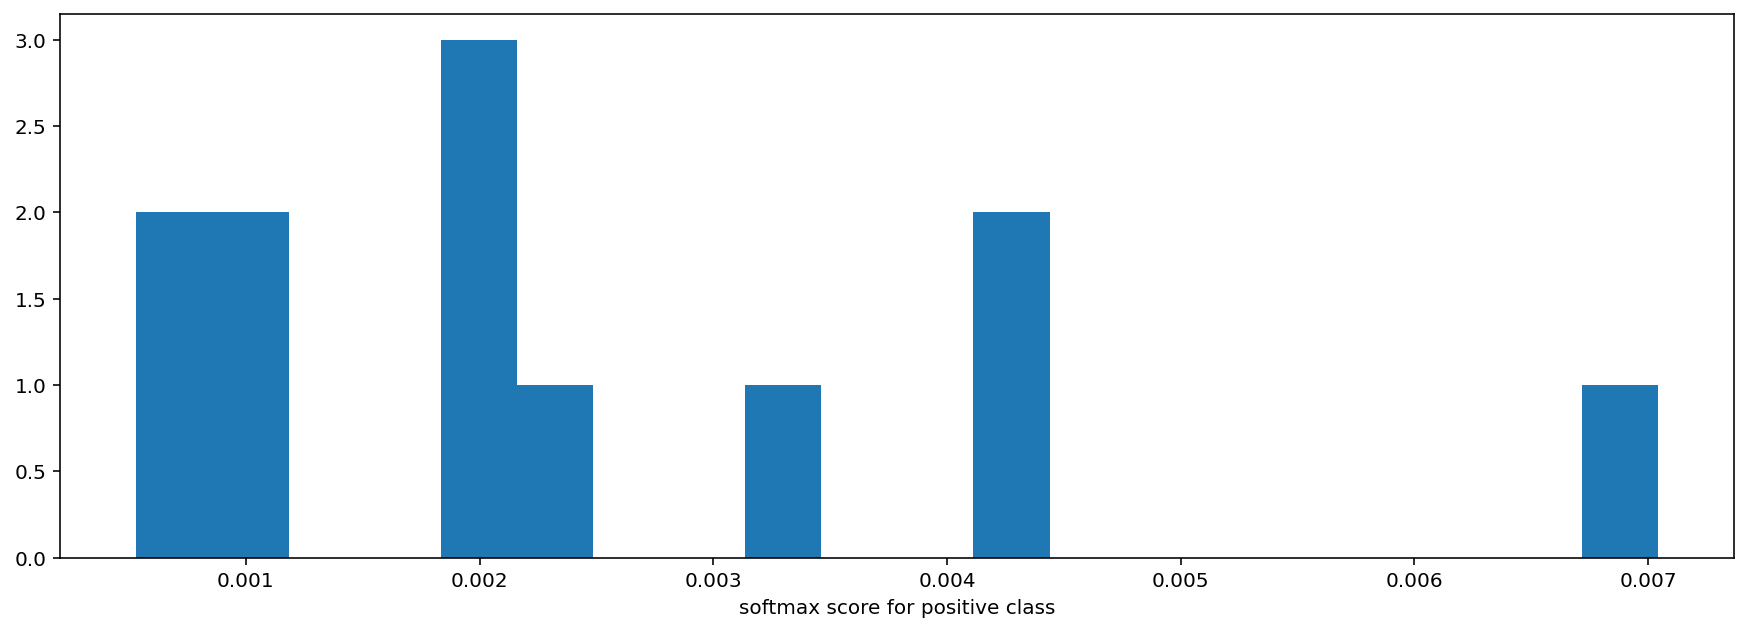

In [63]:
_ = plt.hist(scores['acanthis-flammea-present'],bins=20)
_ = plt.xlabel('softmax score for class')

### Clean up: delete model objects

In [69]:
from pathlib import Path
for p in Path('.').glob('*.model'):
    p.unlink()
for p in Path('.').glob('*.tar'):
    p.unlink()
Path('1min_audio.wav').unlink()

FileNotFoundError: [Errno 2] No such file or directory: '1min_audio.wav'